In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

from copy import deepcopy
import missingno as msno
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from joblib import Parallel, delayed
from skopt.space import Real, Integer, Categorical
from tqdm import tqdm

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

from LRE import LogisticRegressionEnsemble

# The necessary EDA steps that has to be done for the logistic regression ensemble is the following:

- Handle missing values
- Feature Scaling of continuous features
- One hot encode the categorical features
- Encode the target features

# Banana quality

In [3]:
banana_df = pd.read_csv('data/banana_quality.csv')
banana_df

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good
...,...,...,...,...,...,...,...,...
7995,-6.414403,0.723565,1.134953,2.952763,0.297928,-0.156946,2.398091,Bad
7996,0.851143,-2.217875,-2.812175,0.489249,-1.323410,-2.316883,2.113136,Bad
7997,1.422722,-1.907665,-2.532364,0.964976,-0.562375,-1.834765,0.697361,Bad
7998,-2.131904,-2.742600,-1.008029,2.126946,-0.802632,-3.580266,0.423569,Bad


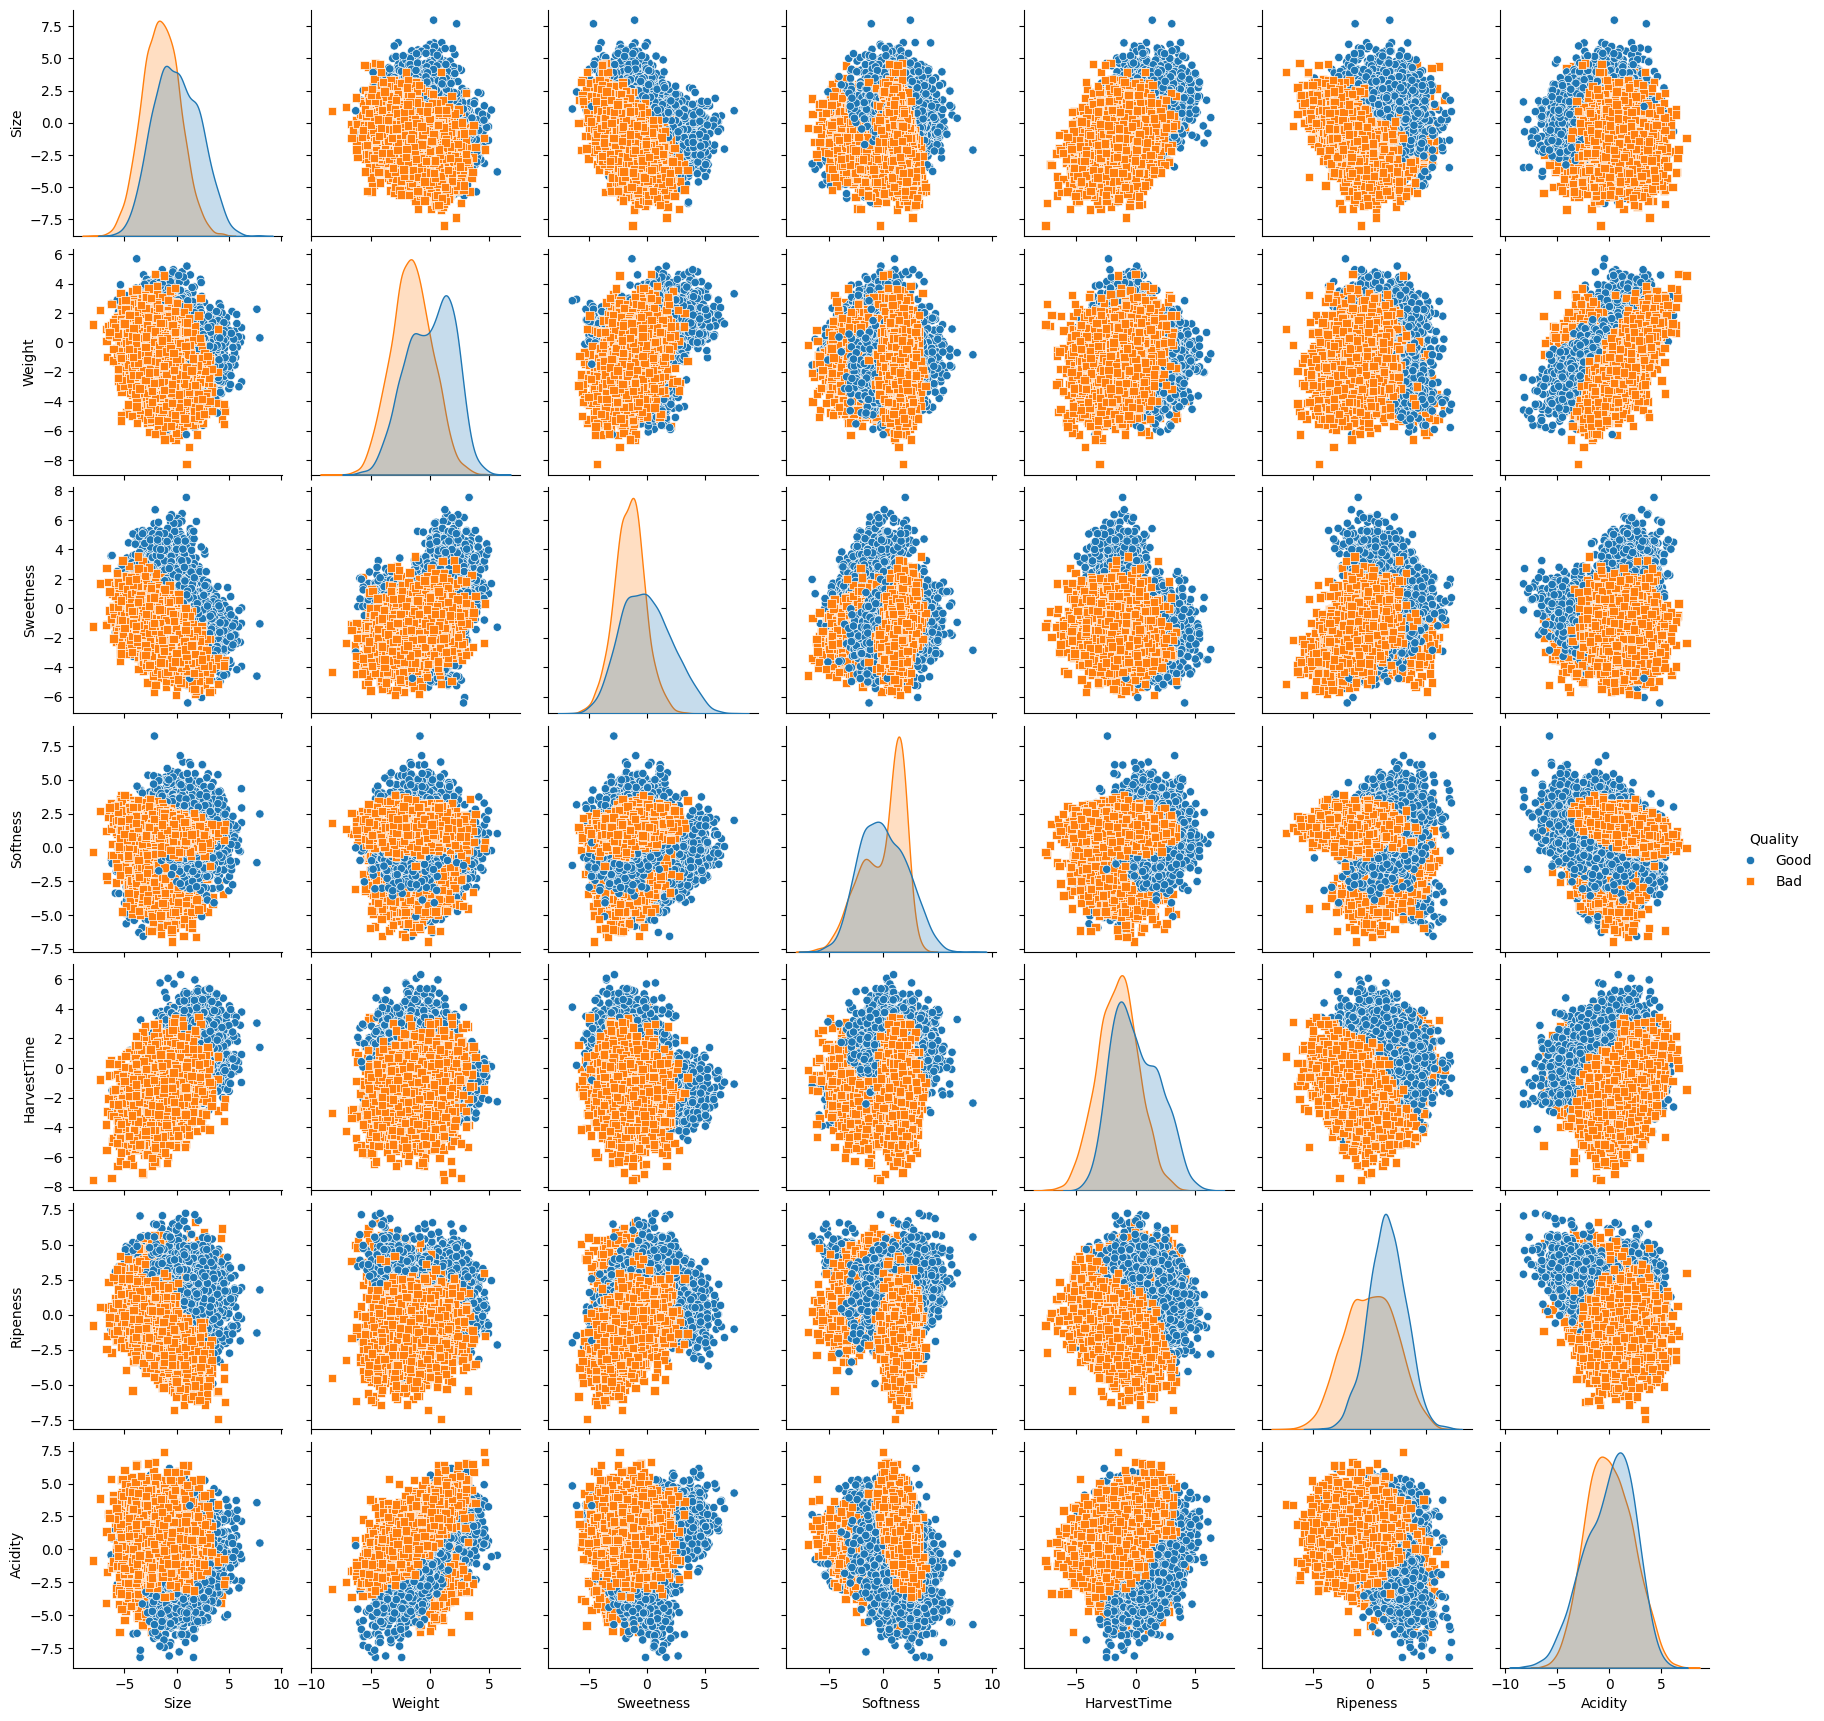

In [4]:
sns.pairplot(banana_df, hue='Quality', diag_kind='kde', markers=["o", "s"])

### Normalisation of the continuous features (Between [-1,1])

In [4]:
X = banana_df.drop("Quality", axis=1)
y = banana_df['Quality']

In [5]:
X_norm = 2 * ((X - X.min()) / (X.max() - X.min())) - 1
X_norm.describe()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-0.091950,0.077440,-0.189346,-0.086253,-0.016291,0.118341,0.053252
std,0.267523,0.288760,0.278881,0.271723,0.288050,0.288204,0.293308
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.283553,-0.132055,-0.380724,-0.293612,-0.213845,-0.066407,-0.156252
50%,-0.110700,0.062022,-0.225192,-0.057691,-0.042678,0.143402,0.064764
75%,0.083644,0.297528,-0.034584,0.119204,0.165284,0.320158,0.267253
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### There is no categorical features to encode, so only encode the target feature

In [6]:
y_encoded = [0 if u == 'Bad' else 1 for u in y]
y_encoded = np.asarray(y_encoded)

In [7]:
X_final = np.asarray(X_norm)

### Start by using Bayesian optimisation to tune the learning rate, epochs and patience parameters

In [8]:
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, num_features=1)

    model.random_state = fold_num
    weights, loss = model.fit_single_model(model.apply_polynomial_features(X_train), y_train, X_val=model.apply_polynomial_features(X_val), y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test) @ weights)])
    score = np.mean(y_pred == y_test)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 6320, 9]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5632
Function value obtained: 0.0636
Current minimum: 0.0636
Iteration No: 2 started. Evaluating function at random point.
[0.006173770394704579, 13929, 5]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3168
Function value obtained: 0.0623
Current minimum: 0.0623
Iteration No: 3 started. Evaluating function at random point.
[0.0023864188780056083, 10678, 6]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9290
Function value obtained: 0.0623
Current minimum: 0.0623
Iteration No: 4 started. Evaluating function at random point.
[0.008967376801947965, 2636, 9]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5072
Function value obtained: 0.0623
Current minimum: 0.0623
Iteration No: 5 started. Evaluating function at random point.
[0.06541210527692738, 1023, 10]
Ite

In [ ]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "accuracy_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models, bag_size=bag_size, num_features=num_features, n_jobs=6, learning_rate=0.0002349840462180413,
                    patience=5, iterations=4338, random_state=42)
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                score = model.score(X_test, y_test)
                
                # Append results for each fold
                results = pd.concat([results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "accuracy_score": score
                    }])], ignore_index=True)

# Save the results DataFrame to a JSON file
results.to_csv("results/banana_linear_results.csv", index=False)

## Non-linear

In [11]:
def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience, num_nonlinear_features, polynomial_degree = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, polynomial_degree=polynomial_degree,
                                       num_features=1, num_nonlinear_features=num_nonlinear_features)

    model.random_state = fold_num

    X_transform = model.apply_polynomial_features(X_train)
    nonlinear_feature_idx = model.select_random_features(X_transform, fold_num)
    
    weights, loss = model.fit_single_model(X_transform[:, nonlinear_feature_idx], y_train, X_val=model.apply_polynomial_features(X_val)[:, nonlinear_feature_idx], y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test)[:,nonlinear_feature_idx] @ weights)])
    score = np.mean(y_pred == y_test)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
    Categorical([0.4, 0.5, 0.6, 0.7, 0.8], name='num_nonlinear_features'),
    Integer(2,3, name='polynomial_degree')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")
print(f"Number of nonlinear features: {result.x[3]}")
print(f"Polynomial degree: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 2651, 9, 0.6, 2]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8089
Function value obtained: 0.1110
Current minimum: 0.1110
Iteration No: 2 started. Evaluating function at random point.
[0.00019949166150633933, 5133, 7, 0.4, 3]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.3249
Function value obtained: 0.0627
Current minimum: 0.0627
Iteration No: 3 started. Evaluating function at random point.
[0.00014765043713594345, 7498, 10, 0.4, 3]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 26.4590
Function value obtained: 0.0608
Current minimum: 0.0608
Iteration No: 4 started. Evaluating function at random point.
[0.007119418600172993, 6505, 5, 0.4, 3]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.6400
Function value obtained: 0.0366
Current minimum: 0.0366
Iteration No: 5 started. Evaluating function at random point

In [ ]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]
# Initialize a DataFrame to store results
nl_results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "accuracy_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models,
                    bag_size=bag_size,
                    num_features=num_features,
                    n_jobs=6,
                    learning_rate=0.010988100318524612,
                    patience=5,
                    polynomial_degree=3,
                    num_nonlinear_features=0.8,
                    iterations=5054,
                    random_state=42
                )
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                score = model.score(X_test, y_test)
                
                # Append results for each fold
                nl_results = pd.concat([nl_results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "accuracy_score": f1
                    }])], ignore_index=True)
# Save the results DataFrame to a JSON file
nl_results.to_csv("results/banana_nonlinear_results.csv", index=False)